In [27]:
# Cella 1: Könyvtárak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [28]:
# Cella 2: Adatok beolvasása
df = pd.read_csv("dataset.csv")

# Célváltozók: xG értékek
print("Adatsor hossza:", len(df))
df[['expected_goals_xg_home', 'expected_goals_xg_host']].describe()

# Formátum
df['Ball_Possession_Home'] = df['Ball_Possession_Home'].str.replace("%", "").astype(float)
df['Ball_Possession_Host'] = df['Ball_Possession_Host'].str.replace("%", "").astype(float)


Adatsor hossza: 95384


C:\Users\Adam\AppData\Local\Temp\ipykernel_15928\1098599122.py:2: DtypeWarning: Columns (4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")


In [35]:
# Cella 3: Kiterjesztett feature lista
features = [
    'Ball_Possession_Home',
    'Goal_Attempts_Home',
    'Shots_on_Goal_Home',
    'Shots_off_Goal_Home',
    'Blocked_Shots_Home',
    'Corner_Kicks_Home',
    'Free_Kicks_Home',
    'Dangerous_Attacks_Home',
    'Attacks_Home',
    'Goalkeeper_Saves_Home',
]

# Derived feature kiszámítása – csak akkor használd, ha elég adat van
df['Shot_Accuracy_Home'] = df['Shots_on_Goal_Home'] / (df['Goal_Attempts_Home'] + 1e-3)
features.append('Shot_Accuracy_Home')
df['Shot_Accuracy_Host'] = df['Shots_on_Goal_Host'] / (df['Goal_Attempts_Host'] + 1e-3)
features.append('Shot_Accuracy_Host')

target_home = 'expected_goals_xg_home'

# Vendég csapat esetére másolat készítése
features_away = [f.replace("_Home", "_Host") for f in features]
target_away = 'expected_goals_xg_host'


In [36]:
# Cella 4: Hiányzó értékek vizsgálata
subset_cols = features + features_away + [target_home, target_away]
missing_per_column = df[pd.notna(df['expected_goals_xg_home'])][subset_cols].isnull().sum()
missing_per_column = missing_per_column[missing_per_column > 0].sort_values(ascending=False)
print(missing_per_column)

df_clean = df.dropna(subset=features + features_away + [target_home, target_away])
print(df_clean)

Attacks_Home              2316
Dangerous_Attacks_Home    2316
Dangerous_Attacks_Host    2316
Attacks_Host              2316
Blocked_Shots_Host        1555
Blocked_Shots_Home        1555
Free_Kicks_Home            493
Free_Kicks_Host            493
dtype: int64
       Country     League         home_team           away_team home_score  \
14831  Germany  Dfb-pokal    Kaiserslautern    Bayer Leverkusen          0   
14832  Germany  Dfb-pokal  Bayer Leverkusen          Dusseldorf          4   
14833  Germany  Dfb-pokal       Saarbrucken      Kaiserslautern          0   
14834  Germany  Dfb-pokal       Saarbrucken  B. Monchengladbach          2   
14835  Germany  Dfb-pokal  Bayer Leverkusen           Stuttgart          3   
...        ...        ...               ...                 ...        ...   
56635  England     Fa-cup   Manchester City       Sheffield Utd          3   
56636  England     Fa-cup    Manchester Utd           Fulham\n2          3   
56637  England     Fa-cup          Br

In [37]:
# Cella 5: Train-test split
X_home = df_clean[features]
y_home = df_clean[target_home]

X_away = df_clean[features_away]
y_away = df_clean[target_away]

X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(X_home, y_home, test_size=0.2, random_state=42)
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(X_away, y_away, test_size=0.2, random_state=42)

In [38]:
# Cella 6: Random Forest regresszor
model_home = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_home.fit(X_train_home, y_train_home)

model_away = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_away.fit(X_train_away, y_train_away)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
# Cella 7: Eredmények
def evaluate(model, X_test, y_test, label=""):
    preds = model.predict(X_test)
    print(f"{label} R²: {r2_score(y_test, preds):.3f}")
    print(f"{label} MAE: {mean_absolute_error(y_test, preds):.3f}")
    print(f"{label} RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.3f}")
    return preds

print("⚽ Hazai csapat predikció:")
preds_home = evaluate(model_home, X_test_home, y_test_home, "Home")

print("\n🛫 Vendég csapat predikció:")
preds_away = evaluate(model_away, X_test_away, y_test_away, "Away")


⚽ Hazai csapat predikció:
Home R²: 0.334
Home MAE: 0.486
Home RMSE: 0.634

🛫 Vendég csapat predikció:
Away R²: 0.469
Away MAE: 0.416
Away RMSE: 0.547


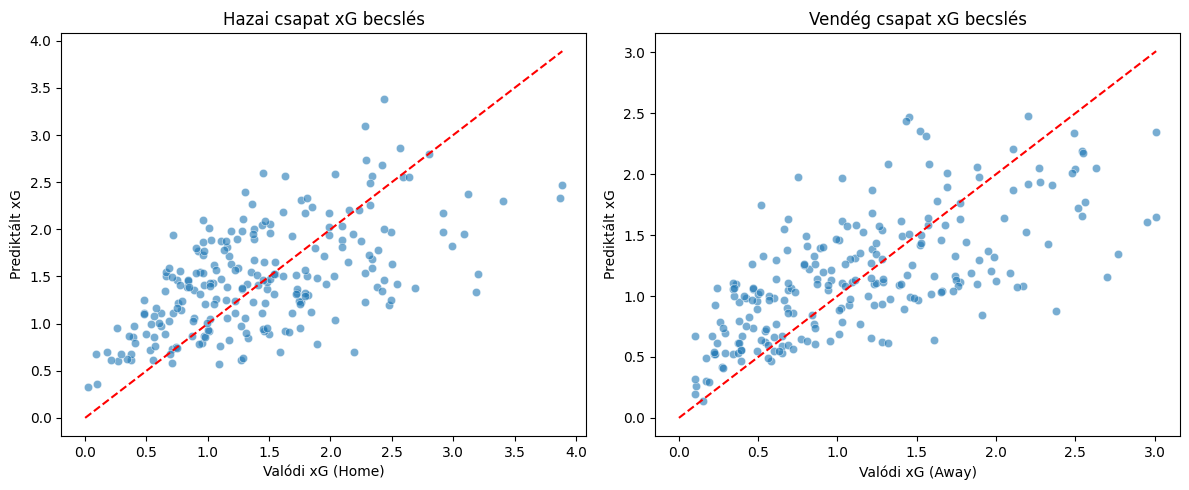

In [34]:
# Cella 8: Predikció vs Valódi xG
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_home, y=preds_home, alpha=0.6)
plt.plot([0, max(y_test_home)], [0, max(y_test_home)], 'r--')
plt.xlabel("Valódi xG (Home)")
plt.ylabel("Prediktált xG")
plt.title("Hazai csapat xG becslés")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_away, y=preds_away, alpha=0.6)
plt.plot([0, max(y_test_away)], [0, max(y_test_away)], 'r--')
plt.xlabel("Valódi xG (Away)")
plt.ylabel("Prediktált xG")
plt.title("Vendég csapat xG becslés")

plt.tight_layout()
plt.show()


In [68]:
from scipy.stats import poisson

xg_home = 2
xg_away = 1.1

max_goals = 6  # elég a 0–6 gólokig
prob_matrix = np.zeros((max_goals+1, max_goals+1))

for i in range(max_goals + 1):
    for j in range(max_goals + 1):
        prob_matrix[i, j] = poisson.pmf(i, xg_home) * poisson.pmf(j, xg_away)

home_win = np.sum(np.tril(prob_matrix, -1).T)
draw = np.sum(np.diag(prob_matrix))
away_win = np.sum(np.triu(prob_matrix, 1))

print(home_win, draw, away_win)

0.5775949284202953 0.21399474142189392 0.20372837076916858
